# Code: CMPT 459 Final Group Assignment 

<h2>Table of Contents</h2>

* [1. Data Visualization](#chapter1)
    <!-- * [Section 1.1](#section_1_1) -->
* [2. Data Preprocessing](#chapter2)
    <!-- * [Section 2.1](#section_2_1)
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2) -->
* [3. Feature Selection](#chapter3)
    <!-- * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2) -->
    <!-- * [Section 3.2](#section_3_2) -->
* [4. Mapping the Features](#chapter4)
    <!-- * [Section 4.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_4_1_1)
        * [Sub Section 3.1.2](#sub_section_4_1_2)
    * [Section 4.2](#section_4_2)
        * [Sub Section 3.2.1](#sub_section_4_2_1) -->
* [5. Balancing the Classes in the Training Dataset](#chapter5)
* [6. Building Models and Hyperparameter Tuning](#chapter6)
    * [6.1 KNN](#section_6_1)
        * [6.1.0 Model Implementation](#sub_section_6_1_0)
        * [6.1.1 Training The Model](#sub_section_6_1_1)
        * [6.1.2 Hyperparameter Tuning](#sub_section_6_1_2)
    * [6.2 Random Forest](#section_6_2)
        * [6.2.0 Model Implementation](#sub_section_6_2_0)
        * [6.2.1 Training The Model](#sub_section_6_2_1)
        * [6.2.2 Hyperparameter Tuning](#sub_section_6_2_2)
    * [6.3 Naive Bayes](#section_6_3)
        * [6.3.0 Model Implementation](#sub_section_6_3_0)
        * [6.3.1 Training The Model](#sub_section_6_3_1)
        * [6.3.2 Hyperparameter Tuning](#sub_section_6_3_2)
* [7. Overfitting](#chapter7)
    * [7.1 KNN](#section_7_1)
    * [7.2 Random Forest](#section_7_2)
    * [7.3 Naive Bayes](#section_7_3)
* [8. Comparitive Study](#chapter8)
* [9. Prediction on Test set](#chapter9)

## 1. Data Visualization <a class="anchor" id="chapter1"></a>

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import RandomOverSampler # Make sure to run pip install -U imbalanced-learn to run
from sklearn.naive_bayes import GaussianNB

In [2]:
locations_df = pd.read_csv('Steps-1-2-3/data/location_2021.csv')
cases_train_df = pd.read_csv('Steps-1-2-3/data/cases_2021_train.csv')
cases_test_df = pd.read_csv('Steps-1-2-3/data/cases_2021_test.csv')
countries_continents_df = pd.read_csv('Extra_Datasets/Countries by continents.csv')
population_df = pd.read_csv('Extra_Datasets/world_population.csv')

In [3]:
location_countries = set(locations_df['Country_Region'].unique())
population_countries = set(population_df['Country/Territory'].unique())

in_location_not_population = location_countries - population_countries
print("In 'location_df' but not in 'population_df':", in_location_not_population)

in_population_not_location = population_countries - location_countries
print("In 'population_df' but not in 'location_df':", in_population_not_location)


In 'location_df' but not in 'population_df': {'Czechia', 'Diamond Princess', 'Burma', 'MS Zaandam', 'Kosovo', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Taiwan*', 'Cabo Verde', 'Holy See', 'US', 'Congo (Brazzaville)', 'Summer Olympics 2020', 'Korea, South', 'West Bank and Gaza'}
In 'population_df' but not in 'location_df': {'Aruba', 'Republic of the Congo', 'Nauru', 'Turkmenistan', 'Macau', 'Curacao', 'Montserrat', 'Greenland', 'Faroe Islands', 'Jersey', 'Northern Mariana Islands', 'Sint Maarten', 'British Virgin Islands', 'Taiwan', 'Saint Martin', 'Niue', 'Vatican City', 'Wallis and Futuna', 'Bermuda', 'DR Congo', 'Isle of Man', 'Turks and Caicos Islands', 'Martinique', 'Western Sahara', 'Cape Verde', 'Saint Pierre and Miquelon', 'Czech Republic', 'Tuvalu', 'United States', 'Falkland Islands', 'Tokelau', 'South Korea', 'Reunion', 'North Korea', 'United States Virgin Islands', 'Puerto Rico', 'Palestine', 'Anguilla', 'Saint Barthelemy', 'Guernsey', 'French Guiana', 'New Caledonia', 'Guadelou

In [4]:
country_name_mapping = {
    "Ivory Coast": "Cote d'Ivoire",
    "DR Congo": "Congo (Kinshasa)",
    "Republic of the Congo": "Congo (Brazzaville)",
    "South Korea": "Korea, South",
    "United States": "US",
    "Cape Verde": "Cabo Verde",
    "Myanmar": "Burma",
    "Czech Republic": "Czechia",
    "Taiwan": "Taiwan*",
    "Vatican City": "Holy See",
    "Palestine": "West Bank and Gaza"
}

In [5]:
# Apply mapping to population_df
population_df['Country/Territory'] = population_df['Country/Territory'].replace(country_name_mapping)

In [6]:
country_confirmed_sum = locations_df.groupby('Country_Region')['Confirmed'].sum().reset_index()
location_with_pop_df = country_confirmed_sum.merge(population_df, left_on='Country_Region',
                                                   right_on='Country/Territory', how='left')
location_with_pop_df['Confirmed_per_country'] = location_with_pop_df['Confirmed'] / location_with_pop_df[
    '2022 Population']

print("location_with_pop_df.groupby('Country_Region')['Confirmed'].sum().sort_values(ascending=False)")

location_with_pop_df.groupby('Country_Region')['Confirmed'].sum().sort_values(ascending=False)


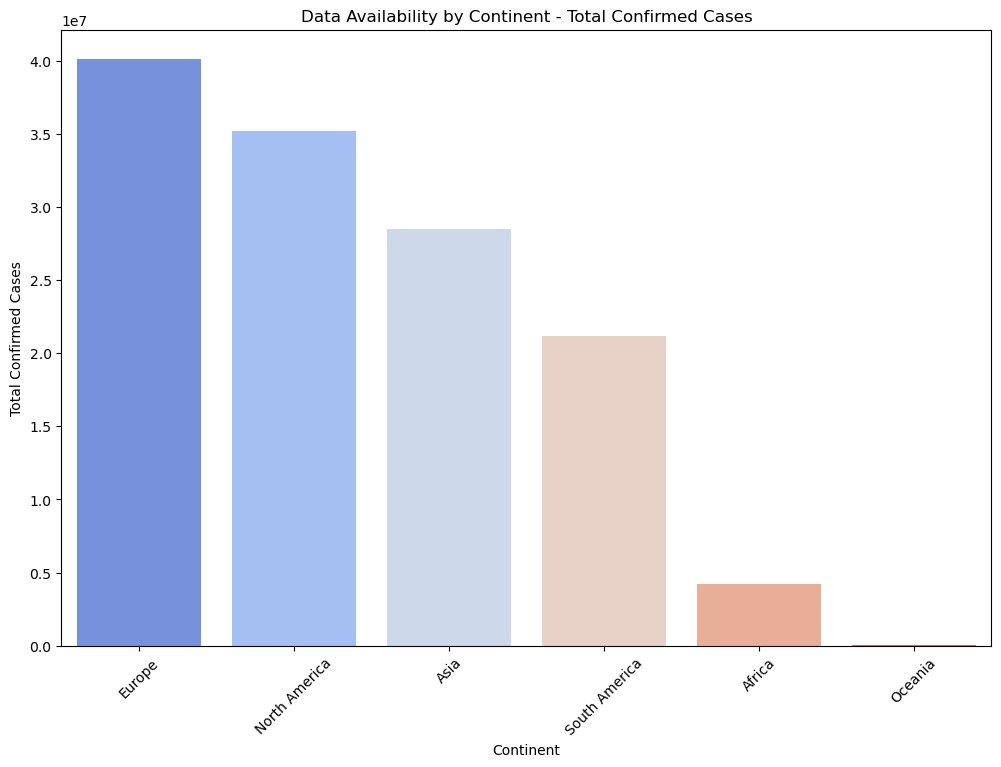

In [7]:
# Calculate data availability by continent using total confirmed cases.
continent_confirmed = location_with_pop_df.groupby('Continent')['Confirmed'].sum().sort_values(ascending=False)

# Visualize data availability by continent with a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=continent_confirmed.index, y=continent_confirmed.values, palette="coolwarm",
            hue=continent_confirmed.index, dodge=False)
plt.title('Data Availability by Continent - Total Confirmed Cases')
plt.xlabel('Continent')
plt.ylabel('Total Confirmed Cases')
plt.xticks(rotation=45)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_27280\54655379.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


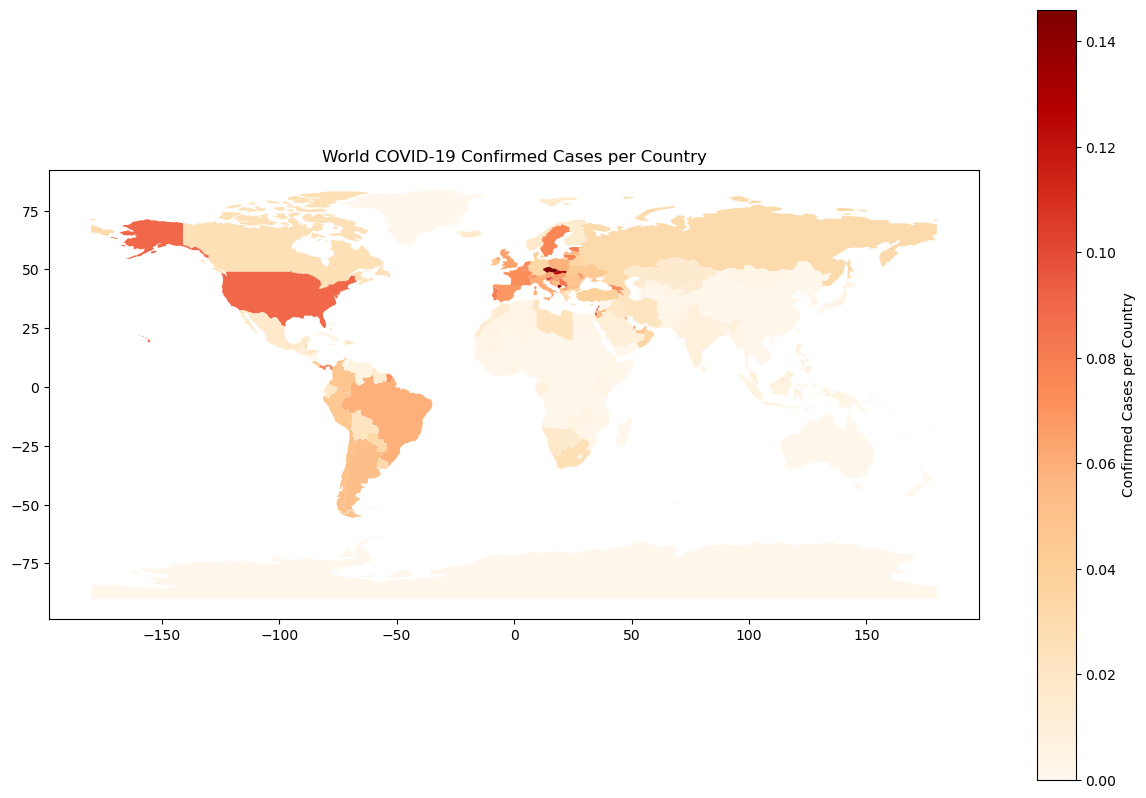

In [8]:
# Load map data (e.g., country geographic data provided by 'naturalearth_lowres')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Country name mistmatch
additional_country_name_mapping = {
    "US": "United States of America",
    "Burma": "Myanmar",
    "Congo (Brazzaville)": "Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Korea, South": "South Korea",
    "Taiwan*": "Taiwan",
    "Holy See": "Vatican City",
    "West Bank and Gaza": "Palestine",
    "Cabo Verde": "Cape Verde",
    "Congo (Kinshasa)": "Dem. Rep. Congo",
    "Dominican Republic": "Dominican Rep.",
    "South Sudan": "S. Sudan",
    "Central African Republic": "Central African Rep.",
    "Equatorial Guinea": "Eq. Guinea",
    "Eswatini": "eSwatini",
    "Bosnia and Herzegovina": "Bosnia and Herz."
}

location_with_pop_df['Country_Region'] = location_with_pop_df['Country_Region'].replace(additional_country_name_mapping)

merged_df = world.merge(location_with_pop_df, left_on='name', right_on='Country_Region', how='left')
merged_df['Confirmed_per_country'] = merged_df['Confirmed_per_country'].fillna(0)

# Visualize map based on confirmed cases per Country
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_df.plot(column='Confirmed_per_country', ax=ax, legend=True,
               legend_kwds={'label': "Confirmed Cases per Country"},
               cmap='OrRd')
plt.title('World COVID-19 Confirmed Cases per Country')
plt.show()

# Note: Although we are required to use both the location and cases csv files and combine them, 
# the cases csv files did not prove helpful in visualizing the data. However, I will demonstrate 
# how they can be combined for completeness.

combined_data = locations_df.merge(cases_train_df, left_on='Country_Region', right_on='country', how='left')

In [9]:
def plot_bar_chart(x_values, y_values, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color='skyblue')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


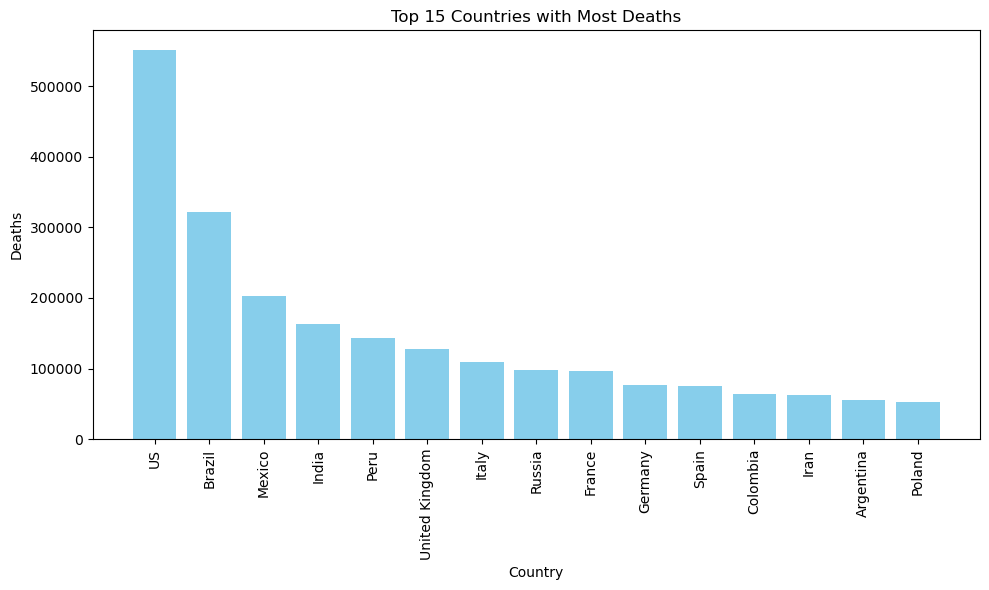

In [10]:
grouped_df = locations_df.groupby('Country_Region')['Deaths'].sum().reset_index()
sorted_df = grouped_df.sort_values(by='Deaths', ascending=False)
top_15_countries = sorted_df.head(15)
plot_bar_chart(top_15_countries['Country_Region'], top_15_countries['Deaths'], 'Country', 'Deaths', 'Top 15 Countries with Most Deaths')

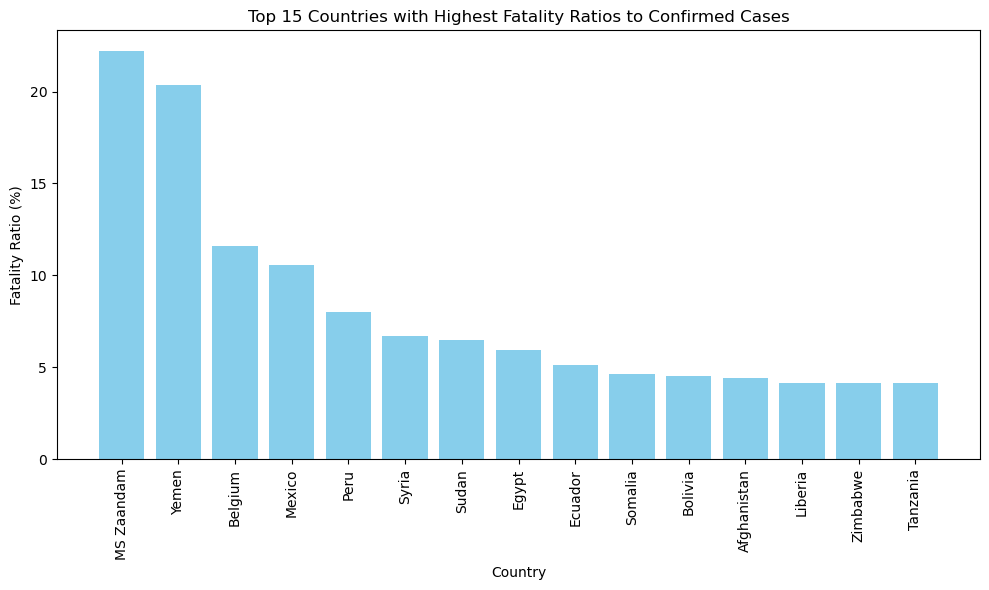

In [11]:
locations_df['Fatality_Ratio'] = (locations_df['Deaths'] / locations_df['Confirmed']) * 100
country_fatality = locations_df.groupby('Country_Region')['Fatality_Ratio'].mean().reset_index()
country_fatality = country_fatality.sort_values(by='Fatality_Ratio', ascending=False).head(15)
plot_bar_chart(country_fatality['Country_Region'], country_fatality['Fatality_Ratio'], 'Country', 'Fatality Ratio (%)', 'Top 15 Countries with Highest Fatality Ratios to Confirmed Cases')

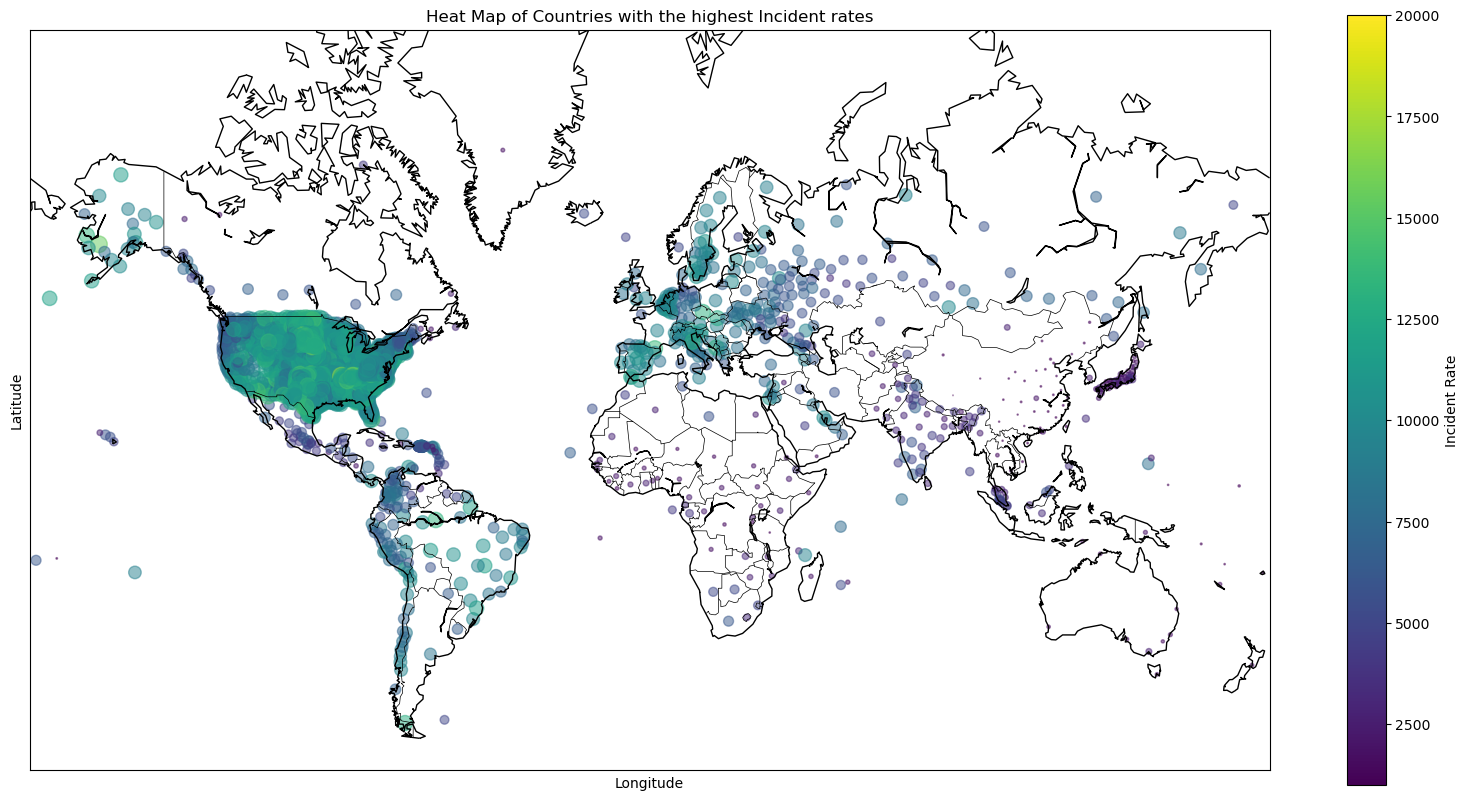

In [12]:
plt.figure(figsize=(20, 10))
plt.title('Heat Map of Countries with the highest Incident rates')

m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()
m.drawcountries()

scatter_sizes = locations_df['Incident_Rate']**0.5
norm = mcolors.Normalize(1000, 20000)
normalized_sizes = norm(scatter_sizes)

# Basemap scatterplot
x, y = m(locations_df['Long_'].values, locations_df['Lat'].values)
scatter_generator = m.scatter(x, y, s=scatter_sizes, c=normalized_sizes, cmap='viridis', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Colorbar with explicit axis specified
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly specify the axis using ax=plt.gca()
cbar.set_label('Incident Rate')

plt.show()

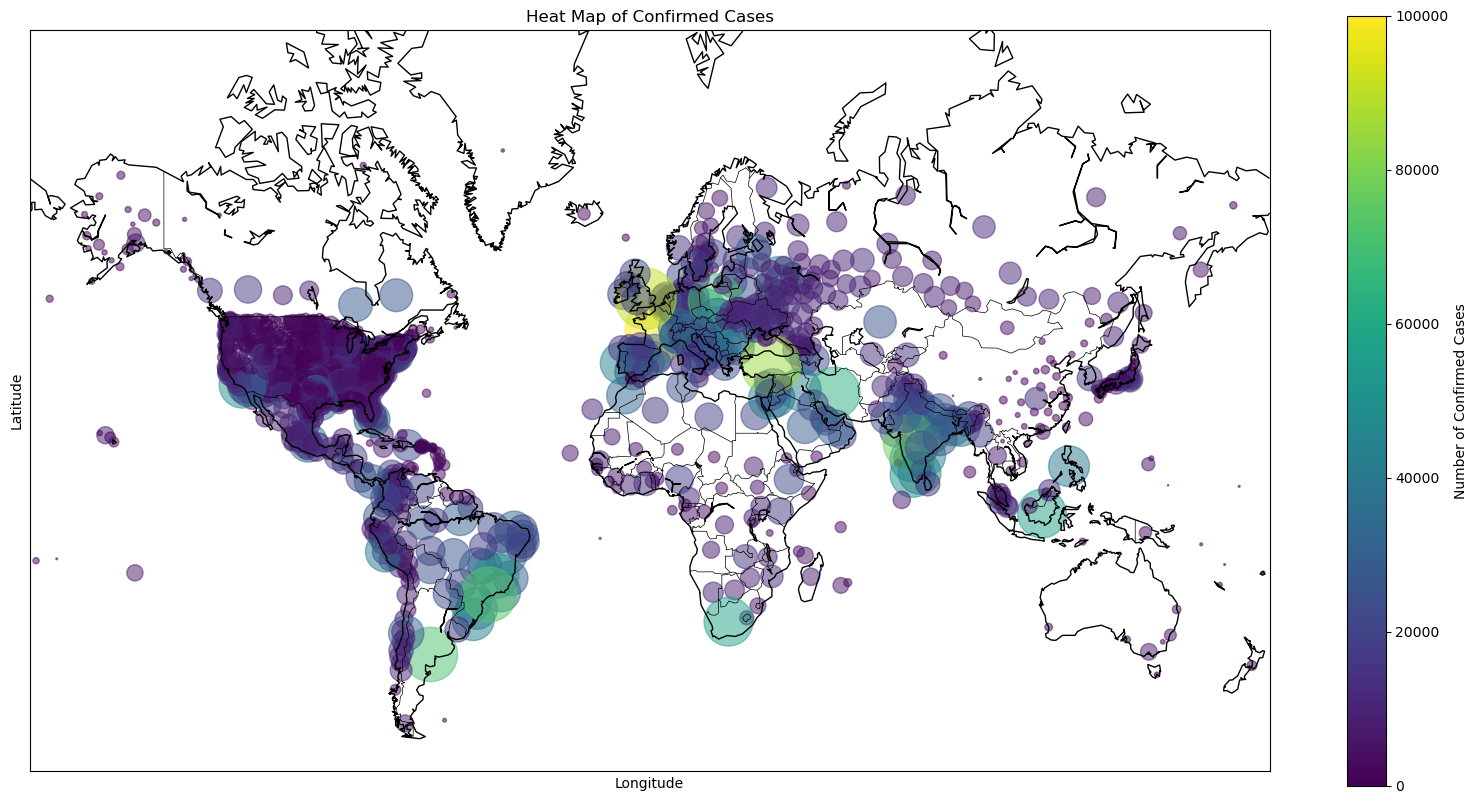

In [13]:
plt.figure(figsize=(20, 10))
plt.title('Heat Map of Confirmed Cases')

m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()
m.drawcountries()

scatter_sizes = locations_df['Confirmed']**0.5
norm = mcolors.Normalize(0, 100000)
normalized_sizes = norm(scatter_sizes)

# Basemap scatterplot for confirmed cases
x, y = m(locations_df['Long_'].values, locations_df['Lat'].values)
scatter_generator = m.scatter(x, y, s=scatter_sizes, c=normalized_sizes, cmap='viridis', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Colorbar with explicit axis specified
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly specify the axis using ax=plt.gca()
cbar.set_label('Number of Confirmed Cases')

plt.show()

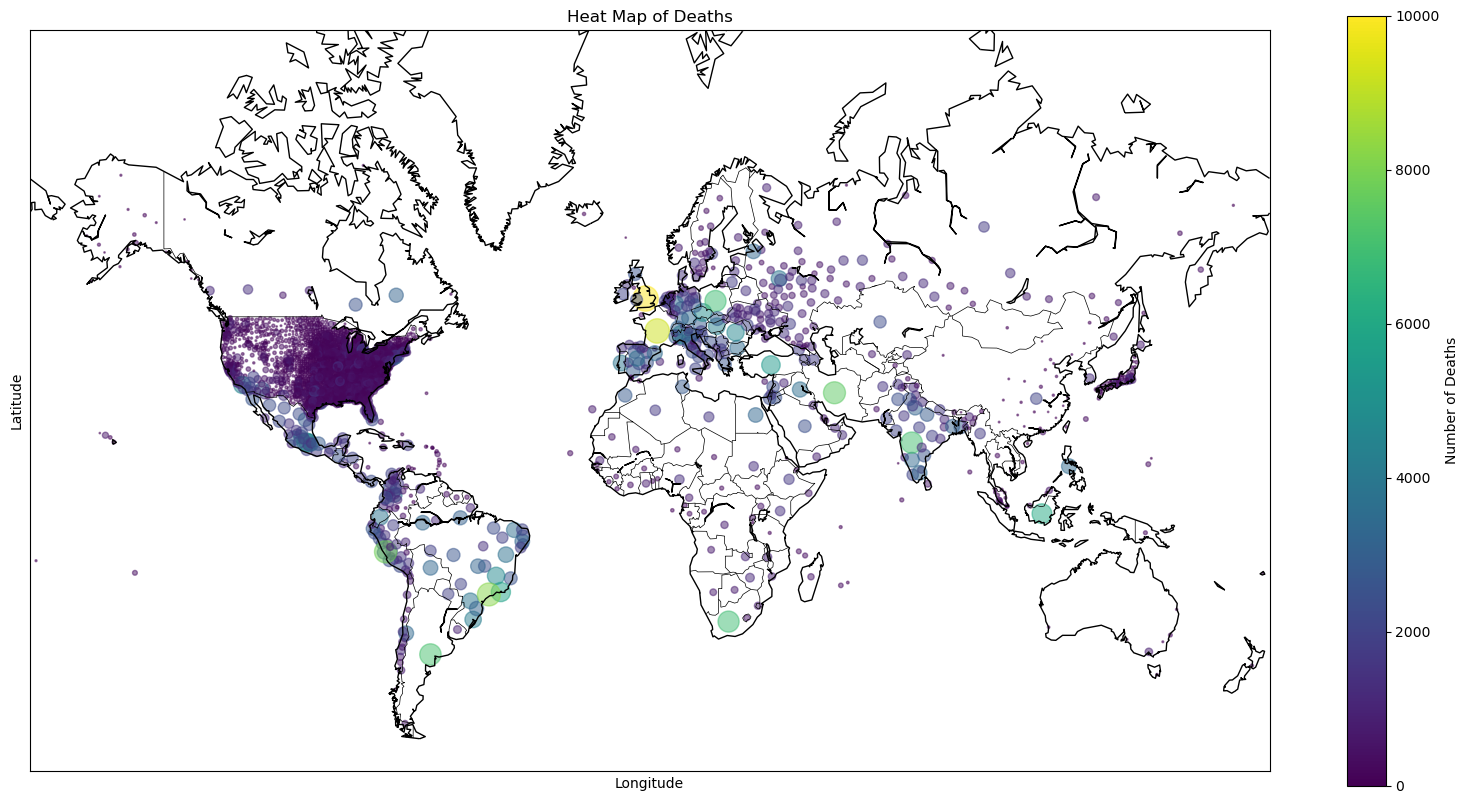

In [14]:
plt.figure(figsize=(20, 10))
plt.title('Heat Map of Deaths')

m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()
m.drawcountries()

scatter_sizes = locations_df['Deaths']**0.5
norm = mcolors.Normalize(0, 10000)
normalized_sizes = norm(scatter_sizes)

# Basemap scatterplot
x, y = m(locations_df['Long_'].values, locations_df['Lat'].values)
scatter_generator = m.scatter(x, y, s=scatter_sizes, c=normalized_sizes, cmap='viridis', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Colorbar with explicit axis specified
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly specify the axis using ax=plt.gca()
cbar.set_label('Number of Deaths')

plt.show()

## 2. Data Preprocessing <a class="anchor" id="chapter2"></a>

In [15]:
print("\nMissing values in train dataset:\n", cases_train_df.isnull().sum())



Missing values in train dataset:
 age                       182793
sex                       180362
province                     604
country                        1
latitude                       0
longitude                      0
date_confirmation             51
additional_information    193444
source                     18394
chronic_disease_binary         0
outcome                        0
outcome_group             205846
dtype: int64


In [16]:
cases_train_df['province'] = cases_train_df['province'].fillna('Unknown')
locations_df['Province_State'] = locations_df['Province_State'].fillna('Unknown')

In [17]:
# Convert 'age' to numeric and coerce errors into NaN
cases_train_df['age'] = pd.to_numeric(cases_train_df['age'], errors='coerce')
cases_test_df['age'] = pd.to_numeric(cases_test_df['age'], errors='coerce')

cases_train_df = cases_train_df.dropna(subset=['age'])
cases_test_df = cases_test_df.dropna(subset=['age'])

cases_train_df['sex'] = cases_train_df['sex'].fillna(-1)  # Using -1 for missing values
cases_test_df['sex'] = cases_test_df['sex'].fillna(-1)


In [18]:
#remove outcome_group and additional information

cases_train_df.drop(columns=['additional_information'], inplace=True)
cases_test_df.drop(columns=['additional_information'], inplace=True)


In [19]:
print("\nMissing values in train dataset after handling:\n", cases_train_df.isnull().sum())


Missing values in train dataset after handling:
 age                           0
sex                           0
province                      0
country                       0
latitude                      0
longitude                     0
date_confirmation            47
source                       93
chronic_disease_binary        0
outcome                       0
outcome_group             22940
dtype: int64


In [20]:
# Convert 'age' column to numeric type, coerce errors to NaN
cases_train_df['age'] = pd.to_numeric(cases_train_df['age'], errors='coerce')
cases_test_df['age'] = pd.to_numeric(cases_test_df['age'], errors='coerce')

# - Remove unlikely ages from dataset

cases_train_df = cases_train_df[(cases_train_df['age'] >= 0) & (cases_train_df['age'] < 105)]
cases_test_df = cases_test_df[(cases_test_df['age'] >= 0) & (cases_test_df['age'] < 105)]

# - Remove unlikely Long/Lat from dataset

cases_train_df = cases_train_df[(cases_train_df['latitude'] >= -90) & (cases_train_df['latitude'] < 90)]
cases_train_df = cases_train_df[(cases_train_df['longitude'] >= -180) & (cases_train_df['longitude'] < 180)]
cases_test_df = cases_test_df[(cases_test_df['longitude'] >= -180) & (cases_test_df['longitude'] < 180)]
cases_test_df = cases_test_df[(cases_test_df['latitude'] >= -90) & (cases_test_df['latitude'] < 90)] 


# - Remove if province is unknown - The long and lat is missing
locations_df = locations_df.dropna(subset=['Lat', 'Long_'], how='any')

In [21]:
# Combine datasets
combined_df = pd.merge(
    cases_train_df,
    locations_df,
    left_on=['country', 'province'],
    right_on=['Country_Region', 'Province_State'],
    how='left'
)

# Combine datasets
combined_test_df = pd.merge(
    cases_test_df,
    locations_df,
    left_on=['country', 'province'],
    right_on=['Country_Region', 'Province_State'],
    how='left'
)

In [22]:
columns_to_drop = ['Lat', 'Long_', 'Province_State', 'Country_Region']
combined_df.drop(columns_to_drop, axis=1, inplace=True)
combined_test_df.drop(columns_to_drop, axis=1, inplace=True)

In [23]:
# Calculate Expected_Mortality_Rate
combined_df['Deaths'] = combined_df['Deaths'].fillna(0)
combined_df['Confirmed'] = combined_df['Confirmed'].fillna(0)
combined_df['Expected_Mortality_Rate'] = combined_df.apply(
    lambda row: (row['Deaths'] / row['Confirmed']) if row['Confirmed'] > 0 else 0,
    axis=1
)

# Calculate Expected_Mortality_Rate
combined_test_df['Deaths'] = combined_test_df['Deaths'].fillna(0)
combined_test_df['Confirmed'] = combined_test_df['Confirmed'].fillna(0)
combined_test_df['Expected_Mortality_Rate'] = combined_test_df.apply(
    lambda row: (row['Deaths'] / row['Confirmed']) if row['Confirmed'] > 0 else 0,
    axis=1
)

In [24]:
print("\nMissing values in combined train dataset:\n", combined_df.isnull().sum())



Missing values in combined train dataset:
 age                            0
sex                            0
province                       0
country                        0
latitude                       0
longitude                      0
date_confirmation             47
source                        93
chronic_disease_binary         0
outcome                        0
outcome_group              22940
Last_Update                 3071
Confirmed                      0
Deaths                         0
Recovered                   3071
Active                      3071
Combined_Key                3071
Incident_Rate               3071
Case_Fatality_Ratio         3071
Fatality_Ratio              3071
Expected_Mortality_Rate        0
dtype: int64


In [25]:
cases_train_df = combined_df.copy()
cases_test_df = combined_test_df.copy()

# Check the data after handling missing values
print(cases_train_df.head())
print(cases_test_df.head())


    age     sex    province country  latitude  longitude date_confirmation  \
0  40.0  female  Tamil Nadu   India  13.08362   80.28252        17.05.2020   
1  37.0      -1  Tamil Nadu   India  12.68224   79.98008        04.05.2020   
2  40.0      -1  Tamil Nadu   India   8.96350   77.30821        04.05.2020   
3  27.0    male  Tamil Nadu   India  13.08362   80.28252        13.05.2020   
4  54.0    male  Tamil Nadu   India  10.38486   78.79294        27.05.2020   

                                              source  chronic_disease_binary  \
0  https://stopcorona.tn.gov.in/wp-content/upload...                   False   
1  https://stopcorona.tn.gov.in/wp-content/upload...                   False   
2  https://stopcorona.tn.gov.in/wp-content/upload...                   False   
3  https://stopcorona.tn.gov.in/wp-content/upload...                   False   
4  https://stopcorona.tn.gov.in/wp-content/upload...                   False   

        outcome  ...          Last_Update Confirme

## 3. Feature Selection <a class="anchor" id="chapter3"></a>

In [26]:
train_df = pd.read_csv('Steps-4-5/data/cases_2021_train_processed_2.csv')
test_df = pd.read_csv('Steps-4-5/data/cases_2021_test_processed_unlabelled_2.csv')

In [27]:
selected_features = ['age', 'sex', 'chronic_disease_binary', 'latitude', 'longitude', 'Deaths',
                     'Recovered', 'Confirmed']

In [28]:
numerical_features = ['age', 'latitude', 'longitude', 'Deaths',
                      'Recovered', 'Confirmed', 'Active', 'Incident_Rate', 'Case_Fatality_Ratio']
scaler = StandardScaler()
scaler.fit(cases_train_df[numerical_features])
train_df[numerical_features] = scaler.transform(train_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

## 4. Feature Mapping <a class="anchor" id="chapter4"></a>

In [29]:
train_df['sex'] = pd.Categorical(train_df['sex'])
train_df['sex'] = train_df['sex'].cat.codes

test_df['sex'] = pd.Categorical(test_df['sex'])
test_df['sex'] = test_df['sex'].cat.codes

print(train_df.head())
print(test_df.head())

        age  sex    province      country  latitude  longitude  \
0 -1.144364    0       Bihar        India  2.035660   0.034302   
1 -0.623089    0         NaN  Philippines -1.466400   2.536174   
2  0.477380    1  Tamil Nadu        India -0.323134  -0.322519   
3 -0.970606    0  Tamil Nadu        India -0.323134  -0.322519   
4 -0.623089    1       Bihar        India  2.186353   0.114064   

  date_confirmation  chronic_disease_binary  Confirmed    Deaths  Recovered  \
0        2020-05-18                   False  -1.148205 -1.360127  -1.989688   
1        2020-04-15                   False   0.152463  0.680890  -0.652209   
2        2020-05-02                   False   0.528778  0.580241   0.344231   
3        2020-05-24                   False   0.528778  0.580241   0.344231   
4        2020-05-27                   False  -1.148205 -1.360127  -1.989688   

     Active  Incident_Rate  Case_Fatality_Ratio    outcome_group  
0 -0.746193      -1.953031            -1.841636     hospitali

In [30]:
train_df['chronic_disease_binary'] = pd.Categorical(train_df['chronic_disease_binary'])
train_df['chronic_disease_binary'] = train_df['chronic_disease_binary'].cat.codes

test_df['chronic_disease_binary'] = pd.Categorical(test_df['chronic_disease_binary'])
test_df['chronic_disease_binary'] = test_df['chronic_disease_binary'].cat.codes

In [31]:
train_df['province'] = pd.Categorical(train_df['province'])
train_df['province'] = train_df['province'].cat.codes

test_df['province'] = pd.Categorical(test_df['province'])
test_df['province'] = test_df['province'].cat.codes

In [32]:
train_df['country'] = pd.Categorical(train_df['country'])
train_df['country'] = train_df['country'].cat.codes

test_df['country'] = pd.Categorical(test_df['country'])
test_df['country'] = test_df['country'].cat.codes

In [33]:
outcome_group_mapping = {'deceased': 0, 'hospitalized': 1, 'nonhospitalized': 2}

train_df['outcome_group_mapped'] = train_df['outcome_group'].map(outcome_group_mapping)

outcome_counts = train_df['outcome_group_mapped'].value_counts()
print("outcome_counts")
print(outcome_counts)

outcome_counts
1    13241
2     2974
0      997
Name: outcome_group_mapped, dtype: int64


## 5. Balancing the Classes in the Dataset <a class="anchor" id="chapter5"></a>

In [34]:
print("Original training dataset 'outcome_group' class distribution:")
original_distribution = train_df['outcome_group_mapped'].value_counts()
print(original_distribution)


Original training dataset 'outcome_group' class distribution:
1    13241
2     2974
0      997
Name: outcome_group_mapped, dtype: int64


In [35]:
print("\nMissing values in balanced_cases_train_df:\n", train_df.isnull().sum())



Missing values in balanced_cases_train_df:
 age                       0
sex                       0
province                  0
country                   0
latitude                  0
longitude                 0
date_confirmation         0
chronic_disease_binary    0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
Incident_Rate             0
Case_Fatality_Ratio       0
outcome_group             0
outcome_group_mapped      0
dtype: int64


In [36]:
#-----(BALANCE DATASET CLASSES USING OVERSAMPLING)------  // If country code is -1, that means it is NULL

# X = train_df.drop(['outcome_group_mapped'], axis=1)
X = train_df[selected_features]
y = train_df['outcome_group_mapped']


In [37]:
max_samples = max(train_df['outcome_group_mapped'].value_counts())
ros = RandomOverSampler(sampling_strategy={0: max_samples, 1: max_samples, 2: max_samples})
X_res, y_res = ros.fit_resample(X, y)

In [38]:
balanced_distribution = pd.concat([X_res, pd.DataFrame(y_res, columns=['outcome_group_mapped'])], axis=1)
# resampled_data.to_csv('Steps-4-5/result/oversampled_processed_data.csv', index=False)  # Save resulting file to resampled_data.csv 

In [39]:
print(balanced_distribution['outcome_group_mapped'].value_counts())


1    13241
2    13241
0    13241
Name: outcome_group_mapped, dtype: int64


## 6. Building Models and Hyperparameter Tuning <a class="anchor" id="chapter6"></a>

### 6.1 KNN <a id="section_6_1"></a>
This is section 2.1

#### 6.1.0 Model Implementation <a id="sub_section_6_1_0"></a>

In [40]:
class KNN:
    def __init__(self, k):
        self.k = k
        self.training_features = None
        self.training_labels = None

    def fit(self, X, y):
        self.training_features = X
        self.training_labels = y

    def euclideanDistance(self, sample1, sample2):
        diff = sample1 - sample2
        squared_diff = diff ** 2
        sum_squared_diff = np.sum(squared_diff, axis=1)
        distance = np.sqrt(sum_squared_diff)
        return distance

    def nearestNeighbors(self, test_sample):
        distances = self.euclideanDistance(self.training_features, test_sample)
        sorted_indices = np.argsort(distances)
        nearest_indices = sorted_indices[:self.k]
        neighbors = [self.training_labels[i] for i in nearest_indices]
        return neighbors
    
    def predict(self, test_set):
        predictions=[]
        for test_sample in test_set:
            neighbors=self.nearestNeighbors(test_sample) # Find k nearest neighbors
            labels=[sample for sample in neighbors]
            prediction=max(labels,key=labels.count)
            predictions.append(prediction) # Append prediction to predictions list
        return predictions
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
    
    def get_params(self, deep=True):
        return {'k': self.k}
    
    def set_params(self, **params):
        self.k = params['k']
        return self


#### 6.1.1 Training KNN Model <a id="sub_section_6_1_1"></a>

In [41]:
outcome_feature = 'outcome_group_mapped'

In [42]:
# Print all columns of the DataFrame
print("All Columns:")
print(balanced_distribution.columns)
print(balanced_distribution.head(10))

# Calculate the support of class labels
class_support = balanced_distribution[outcome_feature].value_counts()

print("Class Label Support:")
print(class_support)

balanced_distribution.to_csv('result.csv',index=False)

All Columns:
Index(['age', 'sex', 'chronic_disease_binary', 'latitude', 'longitude',
       'Deaths', 'Recovered', 'Confirmed', 'outcome_group_mapped'],
      dtype='object')
        age  sex  chronic_disease_binary  latitude  longitude    Deaths  \
0 -1.144364    0                       0  2.035660   0.034302 -1.360127   
1 -0.623089    0                       0 -1.466400   2.536174  0.680890   
2  0.477380    1                       0 -0.323134  -0.322519  0.580241   
3 -0.970606    0                       0 -0.323134  -0.322519  0.580241   
4 -0.623089    1                       0  2.186353   0.114064 -1.360127   
5 -0.796848    1                       0  1.839114  -0.016261 -1.360127   
6  1.577849    0                       0  0.881649  -0.589505  7.881654   
7 -0.159734    1                       0  2.032433  -0.054171 -1.360127   
8 -0.912686    1                       0  0.875343  -0.021772 -1.300051   
9 -0.101815    0                       0  1.027878   0.057359 -1.300051   


In [43]:
# balanced_distribution = balanced_distribution.iloc[14000: 26000]
balanced_distribution_KNN = balanced_distribution.copy()


X = balanced_distribution_KNN.iloc[:,:-1].values
y = balanced_distribution_KNN.iloc[:, -1].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)


(31778, 8)
(7945, 8)


In [44]:
model = KNN(3)

# Train the model
model.fit(X_train, y_train)

# Predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


k_fold = KFold(n_splits=4, shuffle=True, random_state=0)


Accuracy: 0.9101321585903084
Precision: 0.9130163957055677
Recall: 0.9101321585903084


#### 6.1.2 Hyperparameter Tuning <a id="sub_section_6_1_2"></a>

In [45]:

# Define the parameter grid for grid search
param_grid = {
    'k': range(3,5)  # Example parameter range for KNN
}

f1_scorer = make_scorer(f1_score, average='macro', labels=[0])  # '0' corresponds to 'deceased'

k_fold = KFold(n_splits=4, shuffle=True, random_state=0)

# Create and fit GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring={ 'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_deceased': f1_scorer}, refit='f1_macro')

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

# Save the results to a text file
results.to_csv('hyperparameter_tuning_results_rf.txt', index=False)

# Report the best parameters and their corresponding scores
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Mean macro F1-score across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_f1_macro']}")
print(f"Mean F1-score on 'deceased' across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_f1_deceased']}")
print(f"Mean overall accuracy across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_accuracy']}")

# Evaluate the best model's performance on the validation dataset
y_val_pred = grid_search.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation set accuracy: {val_accuracy}")

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

report = classification_report(y_val, y_pred, target_names=['deceased', 'hospitalized', 'non_hospitalized'])
print(report)



Best parameters: {'k': 4}
Best cross-validation score: 0.9011878974749147
Mean macro F1-score across the validation sets: 0.9011878974749147
Mean F1-score on 'deceased' across the validation sets: 0.8656534269565753
Mean overall accuracy across the validation sets: 0.9005915028547853
Validation set accuracy: 0.9084959093769667
Best parameters: {'k': 4}
                  precision    recall  f1-score   support

        deceased       0.84      0.91      0.87      2623
    hospitalized       0.98      0.91      0.94      2664
non_hospitalized       0.91      0.91      0.91      2658

        accuracy                           0.91      7945
       macro avg       0.91      0.91      0.91      7945
    weighted avg       0.91      0.91      0.91      7945



### 6.2 Random Forest <a id="section_6_2"></a>


#### 6.2.0 Model Implementation <a id="sub_section_6_2_0"></a>

#### 6.2.1 Training Model <a id="sub_section_6_2_1"></a>

In [46]:
# balanced_distribution = balanced_distribution.iloc[14000: 26000]
balanced_distribution_RF = balanced_distribution.copy()


X = balanced_distribution_RF.iloc[:,:-1].values
y = balanced_distribution_RF.iloc[:, -1].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)

(31778, 8)
(7945, 8)


In [47]:
# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9256135934550032
Precision: 0.928557029705473
Recall: 0.9256135934550032


#### 6.2.2 Hyperparameter Tuning <a id="sub_section_6_2_2"></a>

In [48]:
# Set up the hyperparameter grid for Random Forest including tree count, max depth, and bootstrapping option
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    # 'min_samples_split': [2, 5, 10]
}
f1_scorer = make_scorer(f1_score, average='macro', labels=[0])  # '0' corresponds to 'deceased'
# Initialize GridSearchCV with additional scoring metrics for Random Forest
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_deceased': f1_scorer
    },
    refit='f1_macro'
)
# Perform hyperparameter tuning and model training with grid search
grid_search.fit(X_train, y_train)
# Extract the results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# Save the results to a text file
results.to_csv('hyperparameter_tuning_results_rf.txt', index=False)
# Report the best parameters and their corresponding scores
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Mean macro F1-score across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_f1_macro']}")
print(f"Mean F1-score on 'deceased' across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_f1_deceased']}")
print(f"Mean overall accuracy across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_accuracy']}")

# Evaluate the best model's performance on the validation dataset
y_val_pred = grid_search.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation set accuracy: {val_accuracy}")

print(f"Best parameters: {grid_search.best_params_}")
rf_best_model = grid_search.best_estimator_
y_pred = rf_best_model.predict(X_val)

report = classification_report(y_val, y_pred, target_names=['deceased', 'hospitalized', 'non_hospitalized'])
print(report)

Best parameters: {'bootstrap': False, 'max_depth': None, 'n_estimators': 300}
Best cross-validation score: 0.9263904579280535
Mean macro F1-score across the validation sets: 0.9263904579280535
Mean F1-score on 'deceased' across the validation sets: 0.8980549375187215
Mean overall accuracy across the validation sets: 0.9257662955240569
Validation set accuracy: 0.9262429200755192
Best parameters: {'bootstrap': False, 'max_depth': None, 'n_estimators': 300}
                  precision    recall  f1-score   support

        deceased       0.86      0.94      0.90      2623
    hospitalized       0.97      0.94      0.95      2664
non_hospitalized       0.96      0.90      0.93      2658

        accuracy                           0.93      7945
       macro avg       0.93      0.93      0.93      7945
    weighted avg       0.93      0.93      0.93      7945



### 6.3 Naive Bayes Classifier <a id="section_6_3"></a>


#### 6.3.0 Model Implementation <a id="sub_section_6_3_0"></a>

#### 6.3.1 Training Model <a id="sub_section_6_3_1"></a>

In [49]:
balanced_distribution_Naive_Bayes = balanced_distribution.copy()

X = balanced_distribution_Naive_Bayes.iloc[:,:-1].values
y = balanced_distribution_Naive_Bayes.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


model = GaussianNB()

model.fit(X_train, y_train)

predicted = model.predict(X_test)

# Predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.6728760226557583
Precision: 0.6621311575469567
Recall: 0.6728760226557583


#### 6.3.2 Hyperparameter Tuning <a id="sub_section_6_3_2"></a>

In [50]:

# Define the parameter grid for grid search
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

f1_scorer = make_scorer(f1_score, average='macro', labels=[0])  # '0' corresponds to 'deceased'
k_fold = KFold(n_splits=4, shuffle=True, random_state=0)

# Create and fit GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring={ 'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_deceased': f1_scorer}, refit='f1_macro')

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
# Save the results to a text file
results.to_csv('hyperparameter_tuning_results_rf.txt', index=False)
# Report the best parameters and their corresponding scores
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Mean macro F1-score across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_f1_macro']}")
print(f"Mean F1-score on 'deceased' across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_f1_deceased']}")
print(f"Mean overall accuracy across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_accuracy']}")

# Evaluate the best model's performance on the validation dataset
y_val_pred = grid_search.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation set accuracy: {val_accuracy}")

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

report = classification_report(y_val, y_pred, target_names=['deceased', 'hospitalized', 'non_hospitalized'])
print(report)


Best parameters: {'var_smoothing': 0.02310129700083159}
Best cross-validation score: 0.6118155648086493
Mean macro F1-score across the validation sets: 0.6118155648086493
Mean F1-score on 'deceased' across the validation sets: 0.24396415822611595
Mean overall accuracy across the validation sets: 0.6804393696403459
Validation set accuracy: 0.6849590937696665
Best parameters: {'var_smoothing': 0.02310129700083159}
                  precision    recall  f1-score   support

        deceased       0.67      0.15      0.25      2623
    hospitalized       0.79      0.98      0.87      2664
non_hospitalized       0.60      0.92      0.73      2658

        accuracy                           0.68      7945
       macro avg       0.69      0.68      0.62      7945
    weighted avg       0.69      0.68      0.62      7945



## 7. Overfitting <a class="anchor" id="chapter6"></a>

#### 7.1 KNN <a id="section_7_1"></a>

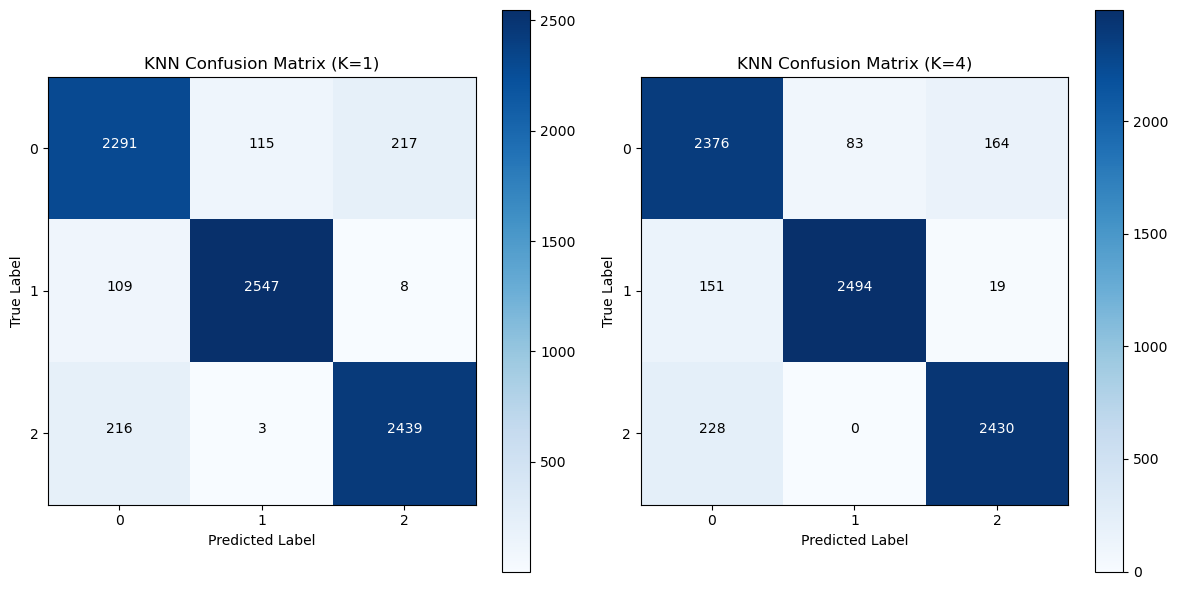

In [51]:
knn_model_k1 = KNN(1)
knn_model_k1.fit(X_train, y_train)

knn_model_k4 = KNN(4)
knn_model_k4.fit(X_train, y_train)

y_val_pred_k1 = knn_model_k1.predict(X_val)
y_val_pred_k4 = knn_model_k4.predict(X_val)

conf_matrix_k1 = confusion_matrix(y_val, y_val_pred_k1)
conf_matrix_k4 = confusion_matrix(y_val, y_val_pred_k4)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_k1, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix (K=1)')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(conf_matrix_k1.shape[0]):
    for j in range(conf_matrix_k1.shape[1]):
        plt.text(j, i, format(conf_matrix_k1[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix_k1[i, j] > conf_matrix_k1.max() / 2 else "black")

plt.subplot(1, 2, 2)
plt.imshow(conf_matrix_k4, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix (K=4)')
plt.colorbar()
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(conf_matrix_k4.shape[0]):
    for j in range(conf_matrix_k4.shape[1]):
        plt.text(j, i, format(conf_matrix_k4[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix_k4[i, j] > conf_matrix_k4.max() / 2 else "black")

plt.tight_layout()
plt.show()

__Confusion Matrix Results__
- K=1 Accuracy: (2276+2467+2396)/7945 = 0.89855
- K=4 Accuracy: (2348+2448+2386)/7945 = 0.90396

#### 7.1 Random Forest <a id="section_7_2"></a>

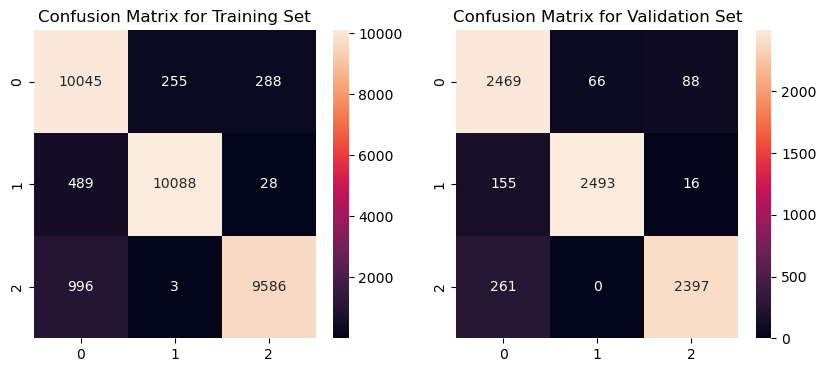

In [52]:
# Predict on the training set
y_train_pred = rf_best_model.predict(X_train)

# Predict on the validation set
y_val_pred = rf_best_model.predict(X_val)

# confusion matrix for training set
cm_train = confusion_matrix(y_train, y_train_pred)
# confusion matrix for validation set
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='g')
plt.title('Confusion Matrix for Training Set')

plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='g')
plt.title('Confusion Matrix for Validation Set')

plt.show()

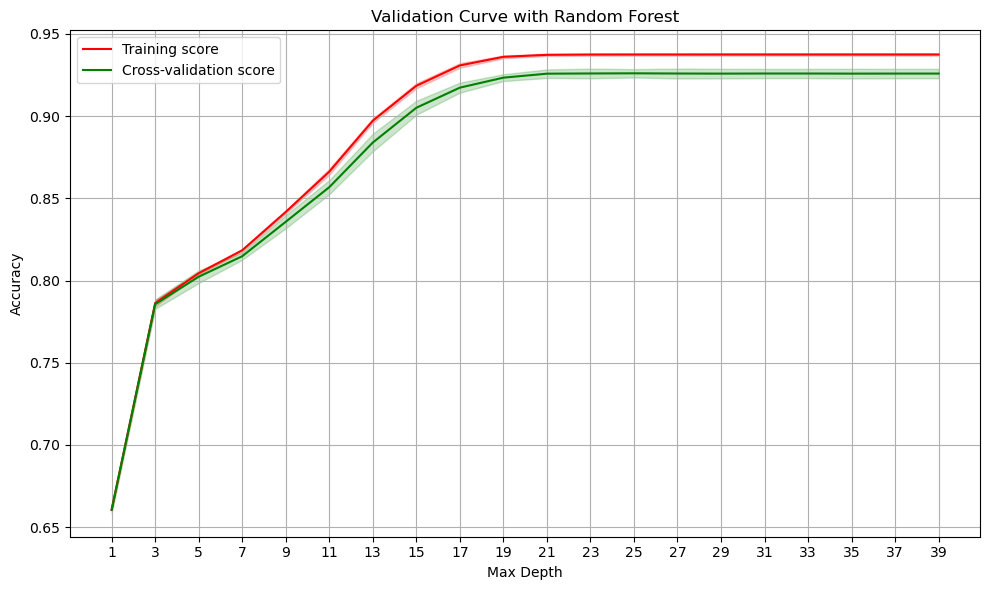

In [53]:
from sklearn.model_selection import validation_curve

# Define the range of the hyperparameter
# varying the 'max_depth' from 1 to 20
param_range = np.arange(1, 40, 2)

# Calculate accuracy on training and validation set using the range of parameter values
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train,
    y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10,6))

plt.plot(param_range, train_mean, label="Training score", color="r")
plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.2)

plt.title("Validation Curve with Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.xticks(param_range)
plt.show()

#### 7.1 Naive Bayes <a id="section_7_3"></a>

## 8. Comparitive Study <a class="anchor" id="chapter8"></a>

## KNN

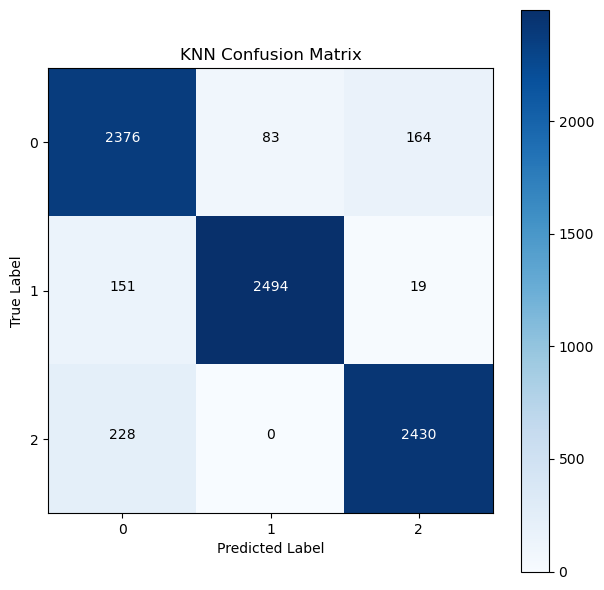

In [54]:

# --------------------------------------------------------------------- confusion matrix
knn_model_k4 = KNN(4)
knn_model_k4.fit(X_train, y_train)


y_val_pred_k1 = knn_model_k4.predict(X_val)

conf_matrix_k1 = confusion_matrix(y_val, y_val_pred_k1)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_k1, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(conf_matrix_k1.shape[0]):
    for j in range(conf_matrix_k1.shape[1]):
        plt.text(j, i, format(conf_matrix_k1[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix_k1[i, j] > conf_matrix_k1.max() / 2 else "black")


plt.tight_layout()
plt.show()

__KNN Confusion Matrix Results__
- Accuracy: (2348+2448+2386)/7945 = 0.90396

## Random Forest

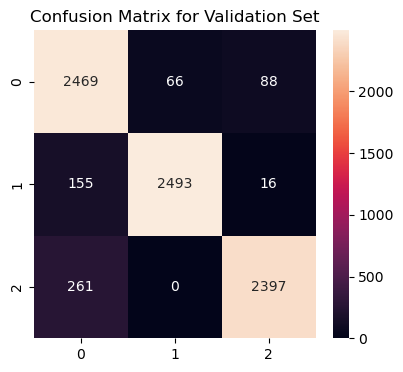

In [55]:
# Predict on the training set
y_train_pred = rf_best_model.predict(X_train)

# Predict on the validation set
y_val_pred = rf_best_model.predict(X_val)

cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='g')
plt.title('Confusion Matrix for Validation Set')

plt.show()

## Naive Bias

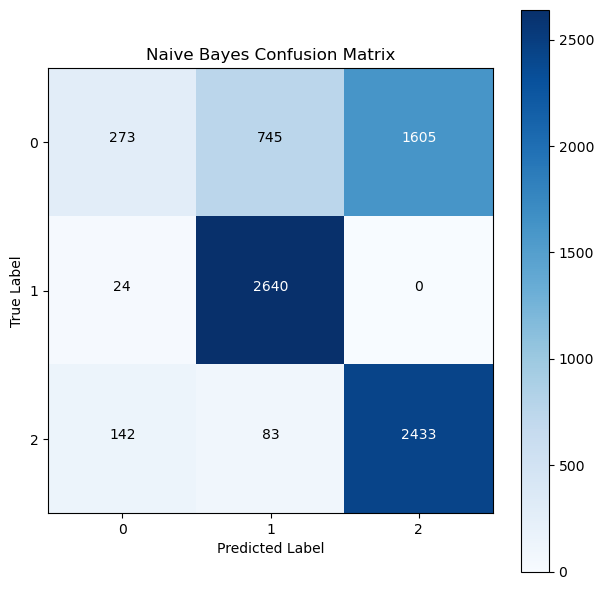

In [56]:

# --------------------------------------------------------------------- confusion matrix
naive_model_k1 = GaussianNB()
naive_model_k1.fit(X_train, y_train)


y_val_pred_k1 = naive_model_k1.predict(X_val)

conf_matrix_k1 = confusion_matrix(y_val, y_val_pred_k1)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_k1, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(conf_matrix_k1.shape[0]):
    for j in range(conf_matrix_k1.shape[1]):
        plt.text(j, i, format(conf_matrix_k1[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix_k1[i, j] > conf_matrix_k1.max() / 2 else "black")


plt.tight_layout()
plt.show()

__Naive Bayes Confusion Matrix Results__
- Accuracy: (222+2640+2421)/7945 = 0.6649465

## 9. Prediction on Test set <a class="anchor" id="chapter9"></a>

In [57]:
# best_model = grid_search.best_estimator_
y_preds = rf_best_model.predict(test_df[selected_features])



def create_submission_file(y_preds, model_name):
    file_name = f"submission_{model_name}.csv"

    with open(file_name, "w", newline='') as csvfile:
        wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
        wr.writerow(["Id", "Prediction"])
        for i, pred in enumerate(y_preds):
            # wr.writerow([i, pred])
            wr.writerow([str(i), str(pred)])


create_submission_file(y_preds, "random_forest")

# def create_submission_file(y_preds, file_name):
#     with open(file_name, "w") as csvfile:
#         wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
#         wr.writerow(["Id", "Prediction"])
#         for i, pred in enumerate(y_preds):
#             wr.writerow([str(i), str(pred)])


# create_submission_file(y_pred, "submission_rf.csv")

C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
